In [ ]:
!pip install -U transformers accelerate datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 23.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [ ]:
!pip install pyngrok

In [ ]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.4 MB/s eta 0:00:00


In [ ]:
pip install --upgrade transformers

In [ ]:
!pip install torch

In [ ]:
pip show transformers

Name: transformers
Version: 4.57.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def parse_csic_file(filepath, fixed_label=None):
    data = []
    with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
        request_lines = []
        label = fixed_label
        req_id = None

        for line in f:
            line = line.strip()

            if line.startswith("Start - Id:"):
                request_lines = []
                req_id = line.split(":")[1].strip()

            elif line.startswith("class:") and not fixed_label:
                label = line.split(":")[1].strip()

            elif line.startswith("End - Id:"):
                data.append({
                    "id": req_id,
                    "label": label,
                    "text": " ".join(request_lines)
                })
                request_lines = []
                req_id = None

            else:
                if line.lower() != "null" and line != "":
                    request_lines.append(line)

    return pd.DataFrame(data)

In [4]:
import pandas as pd

path_base = "/content/drive/MyDrive/CSIC2010"

df_attack_test = parse_csic_file(f"{path_base}/cisc_anomalousTraffic_test.txt", fixed_label="Attack")
df_normal_train = parse_csic_file(f"{path_base}/cisc_normalTraffic_train.txt", fixed_label="Normal")
df_normal_test = parse_csic_file(f"{path_base}/cisc_normalTraffic_test.txt", fixed_label="Normal")

for d in [df_attack_test, df_normal_train, df_normal_test]:
    d["label"] = d["label"].replace({"Normal": 0, "Attack": 1}).astype(int)

print("Original counts:")
print("Normal train:", len(df_normal_train))
print("Normal test:", len(df_normal_test))
print("Attack test:", len(df_attack_test))

train_attacks = df_attack_test.sample(frac=0.2, random_state=42)
train_normals = df_normal_train.sample(n=len(train_attacks), random_state=42)

train_df = pd.concat([train_attacks, train_normals]).sample(frac=1, random_state=42).reset_index(drop=True)

test_df = pd.concat([
    df_attack_test.drop(train_attacks.index),
    df_normal_test
]).sample(frac=1, random_state=42).reset_index(drop=True)

min_class = min(len(df_attack_test), len(df_normal_test))
test_df_bal = pd.concat([
    df_attack_test.sample(n=min_class, random_state=42),
    df_normal_test.sample(n=min_class, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["label"],
    random_state=42
)

print("\nDataset Summary")
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
print(f"Balanced Test size: {len(test_df_bal)}")

print("\n🧾 Label distribution:")
print("Train:\n", train_df["label"].value_counts())
print("Validation:\n", val_df["label"].value_counts())
print("Test:\n", test_df["label"].value_counts())
print("Balanced Test:\n", test_df_bal["label"].value_counts())

/tmp/ipython-input-3062033383.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d["label"] = d["label"].replace({"Normal": 0, "Attack": 1}).astype(int)
/tmp/ipython-input-3062033383.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d["label"] = d["label"].replace({"Normal": 0, "Attack": 1}).astype(int)
/tmp/ipython-input-3062033383.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To op

Original counts:
Normal train: 36000
Normal test: 203299
Attack test: 25065

Dataset Summary
Train size: 9023
Validation size: 1003
Test size: 223351
Balanced Test size: 50130

🧾 Label distribution:
Train:
 label
1    4512
0    4511
Name: count, dtype: int64
Validation:
 label
0    502
1    501
Name: count, dtype: int64
Test:
 label
0    203299
1     20052
Name: count, dtype: int64
Balanced Test:
 label
0    25065
1    25065
Name: count, dtype: int64


In [5]:
import re
from urllib.parse import unquote

def normalize_http_request(text):
    """
    Normalize HTTP requests to preserve attack patterns while preventing overfitting.

    Key principles:
    - Keep attack signatures (SQL injection, XSS, path traversal, etc.)
    - Normalize benign values (IDs, session tokens, legitimate data)
    - Preserve structure and special characters that indicate attacks
    """

    # Decode URL encoding for better pattern detection and model learning
    # The model should see decoded attacks to learn patterns
    decoded = unquote(text)

    # ==================== ATTACK PATTERN DETECTION ====================
    # These patterns should be PRESERVED as they indicate attacks

    attack_indicators = {
        # SQL Injection patterns
        'sql_union': r'(?i)(union\s+(all\s+)?select)',
        'sql_comment': r'(--|#|\/\*|\*\/)',
        'sql_operators': r'(?i)((\s+or\s+|\s+and\s+)\d+\s*=\s*\d+)',
        'sql_keywords': r'(?i)\b(select|insert|update|delete|drop|exec|execute|cast|concat|char|varchar)\b',

        # XSS patterns
        'xss_script': r'(?i)<script[^>]*>.*?</script>',
        'xss_tags': r'(?i)<(iframe|embed|object|img|svg|body|html)',
        'xss_events': r'(?i)on(load|error|click|mouse\w+)\s*=',
        'xss_javascript': r'(?i)javascript:',

        # Path traversal
        'path_traversal': r'\.\.[/\\]',

        # Command injection
        'cmd_injection': r'[;&|`$]',

        # SSI (Server Side Include) injection
        'ssi_injection': r'<!--\s*#\s*(include|exec|echo)',

        # LDAP injection
        'ldap_injection': r'[()&|!*]',

        # XML injection
        'xml_injection': r'(?i)(<!DOCTYPE|<!ENTITY|SYSTEM|PUBLIC)',

        # Special encoded characters often used in attacks
        'encoded_attack': r'%[0-9a-fA-F]{2}[0-9a-fA-F]{2}',
    }

    # Check if this is likely an attack
    is_attack = any(re.search(pattern, decoded) for pattern in attack_indicators.values())

    # ==================== NORMALIZATION ====================

    # Start with decoded text so model can see actual attack patterns
    normalized = decoded

    # 0. CRITICAL: Remove class labels from the text (they leak the answer!)
    normalized = re.sub(
        r'^class:\s*(Attack|Valid|Normal)\s+',
        '',
        normalized,
        flags=re.IGNORECASE
    )

    # 1. Normalize session IDs (these don't indicate attacks)
    normalized = re.sub(
        r'JSESSIONID=[A-F0-9]+',
        'JSESSIONID=<SESSION_ID>',
        normalized
    )

    # 2. Normalize numeric IDs in parameters (but preserve in attack context)
    if not is_attack:
        # Only normalize standalone IDs in normal traffic
        normalized = re.sub(r'(\?|&)id=\d+', r'\1id=<ID>', normalized)
        normalized = re.sub(r'(\?|&)idA=\d+', r'\1idA=<ID>', normalized)

    # 3. Normalize legitimate product data (prices, quantities) in normal traffic
    if not is_attack:
        normalized = re.sub(r'precio=\d+', 'precio=<PRICE>', normalized)
        normalized = re.sub(r'cantidad=\d+', 'cantidad=<QUANTITY>', normalized)

    # 4. Normalize legitimate usernames in normal traffic only
    if not is_attack:
        # Only normalize login values that don't contain attack patterns
        normalized = re.sub(
            r'login=([a-zA-Z0-9_]+)(?!.*(<|>|script|union|select))',
            'login=<USERNAME>',
            normalized
        )

    # 5. Normalize benign passwords (but keep attack payloads in passwords)
    # Only normalize if it's clearly not an attack payload
    if not is_attack:
        normalized = re.sub(
            r'pwd=([a-zA-Z0-9_]+)(?!.*(<|>|script|union|select|--|#))',
            'pwd=<PASSWORD>',
            normalized
        )

    # 6. Normalize legitimate product names
    if not is_attack:
        normalized = re.sub(
            r'nombre=[^&]+&',
            'nombre=<PRODUCT_NAME>&',
            normalized
        )

    # 7. Normalize content lengths (vary but don't indicate attacks)
    normalized = re.sub(
        r'Content-Length: \d+',
        'Content-Length: <LENGTH>',
        normalized
    )

    # 8. Normalize timestamps and dates if present
    normalized = re.sub(
        r'\d{4}-\d{2}-\d{2}',
        '<DATE>',
        normalized
    )
    normalized = re.sub(
        r'\d{2}:\d{2}:\d{2}',
        '<TIME>',
        normalized
    )

    # 9. Normalize IP addresses (if present)
    normalized = re.sub(
        r'\b(?:\d{1,3}\.){3}\d{1,3}\b',
        '<IP_ADDRESS>',
        normalized
    )

    # ==================== PRESERVE ATTACK STRUCTURE ====================
    # DO NOT normalize:
    # - Special characters: <, >, ', ", %, ;, |, &, etc. in attack context
    # - SQL keywords and operators
    # - Script tags and event handlers
    # - Path traversal sequences
    # - Command injection operators
    # - Encoded attack payloads

    return normalized


def batch_normalize(df, text_column='raw_text'):
    """
    Apply normalization to a pandas DataFrame.

    Args:
        df: DataFrame with HTTP request data
        text_column: name of column containing HTTP request text

    Returns:
        DataFrame with new 'normalized_text' column
    """
    df = df.copy()
    df['normalized_text'] = df[text_column].apply(normalize_http_request)
    return df


# Example usage and testing
if __name__ == "__main__":
    # Test cases
    test_cases = [
        # Normal request
        "GET /tienda1/publico/productos.jsp?id=123 HTTP/1.1\nCookie: JSESSIONID=ABC123DEF456",

        # SQL injection attack (should preserve attack pattern)
        "POST /login.jsp HTTP/1.1\nlogin=admin&pwd=test' OR '1'='1'--",

        # XSS attack (should preserve script tags)
        "GET /search.jsp?q=<script>alert('XSS')</script> HTTP/1.1",

        # SSI injection (should preserve SSI directive)
        "POST /login.jsp HTTP/1.1\npwd=CarMinAR<!--#include file=\"secret\"-->",

        # Path traversal (should preserve ../)
        "GET /../../etc/passwd HTTP/1.1",
    ]

    print("Normalization Examples:\n" + "="*80)
    for i, test in enumerate(test_cases, 1):
        print(f"\n{i}. Original:")
        print(test[:100] + "..." if len(test) > 100 else test)
        print(f"\n   Normalized:")
        print(normalize_http_request(test)[:100] + "..." if len(normalize_http_request(test)) > 100 else normalize_http_request(test))
        print("-"*80)

Normalization Examples:

1. Original:
GET /tienda1/publico/productos.jsp?id=123 HTTP/1.1
Cookie: JSESSIONID=ABC123DEF456

   Normalized:
GET /tienda1/publico/productos.jsp?id=123 HTTP/1.1
Cookie: JSESSIONID=<SESSION_ID>
--------------------------------------------------------------------------------

2. Original:
POST /login.jsp HTTP/1.1
login=admin&pwd=test' OR '1'='1'--

   Normalized:
POST /login.jsp HTTP/1.1
login=admin&pwd=test' OR '1'='1'--
--------------------------------------------------------------------------------

3. Original:
GET /search.jsp?q=<script>alert('XSS')</script> HTTP/1.1

   Normalized:
GET /search.jsp?q=<script>alert('XSS')</script> HTTP/1.1
--------------------------------------------------------------------------------

4. Original:
POST /login.jsp HTTP/1.1
pwd=CarMinAR<!--#include file="secret"-->

   Normalized:
POST /login.jsp HTTP/1.1
pwd=CarMinAR<!--#include file="secret"-->
-------------------------------------------------------------------------------

In [6]:
train_df = batch_normalize(train_df, text_column='text')
val_df = batch_normalize(val_df, text_column='text')
test_df_bal = batch_normalize(test_df_bal, text_column='text')

print("Example train normalized:", train_df["normalized_text"].iloc[0])
print("Example validation normalized:", val_df["normalized_text"].iloc[0])
print("Example test normalized:", test_df_bal["normalized_text"].iloc[0])

Example train normalized: POST http://localhost:8080/tienda1/publico/pagar.jsp HTTP/1.1 User-Agent: Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko) Pragma: no-cache Cache-control: no-cache Accept: text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5 Accept-Encoding: x-gzip, x-deflate, gzip, deflate Accept-Charset: utf-8, utf-8;q=0.5, *;q=0.5 Accept-Language: en Host: localhost:8080 Cookie: JSESSIONID=<SESSION_ID> Content-Type: application/x-www-form-urlencoded Connection: close Content-Length: <LENGTH> modoA=insertar&precio=6569&B1=Pasar+por+caja
Example validation normalized: GET http://localhost:8080/CFIDE/administrator/header.cfm HTTP/1.1 User-Agent: Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko) Pragma: no-cache Cache-control: no-cache Accept: text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5 Accept-Encoding: x-gzip, x-deflate, gzip, defl

In [7]:
# Let's check some attack examples to see if patterns are preserved
attack_samples = train_df[train_df['label'] == 1].head(5)

print("🔍 Checking Attack Pattern Preservation:\n")
for idx, row in attack_samples.iterrows():
    original = row['text']
    normalized = row['normalized_text']

    # Check if key attack indicators are still present
    attack_keywords = ['select', 'union', 'script', 'javascript:', '--', '../', '<!--#']
    found_patterns = [kw for kw in attack_keywords if kw.lower() in normalized.lower()]

    print(f"Sample {idx}:")
    print(f"  Attack patterns found: {found_patterns if found_patterns else 'Other attack type'}")
    print(f"  Length - Original: {len(original)}, Normalized: {len(normalized)}")
    print()

# Check normal traffic normalization
normal_samples = train_df[train_df['label'] == 0].head(3)

print("\n🔍 Checking Normal Traffic Normalization:\n")
for idx, row in normal_samples.iterrows():
    original = row['text']
    normalized = row['normalized_text']

    print(f"Sample {idx}:")
    print(f"  Session normalized: {'<SESSION_ID>' in normalized}")
    print(f"  Length - Original: {len(original)}, Normalized: {len(normalized)}")
    print()

🔍 Checking Attack Pattern Preservation:

Sample 9147:
  Attack patterns found: Other attack type
  Length - Original: 625, Normalized: 597

Sample 1836:
  Attack patterns found: Other attack type
  Length - Original: 520, Normalized: 486

Sample 9941:
  Attack patterns found: Other attack type
  Length - Original: 531, Normalized: 497

Sample 3408:
  Attack patterns found: Other attack type
  Length - Original: 589, Normalized: 551

Sample 4488:
  Attack patterns found: Other attack type
  Length - Original: 902, Normalized: 863


🔍 Checking Normal Traffic Normalization:

Sample 2695:
  Session normalized: True
  Length - Original: 526, Normalized: 493

Sample 7138:
  Session normalized: True
  Length - Original: 587, Normalized: 548

Sample 9583:
  Session normalized: True
  Length - Original: 508, Normalized: 475



In [8]:
import re

print("🔍 Detailed Attack Payload Inspection:\n")
print("="*80)

# Get a diverse sample of attacks
attack_samples = train_df[train_df['label'] == 1].sample(10, random_state=42)

for idx, row in attack_samples.iterrows():
    original = row['text']
    normalized = row['normalized_text']

    # Extract the request line (first line)
    request_line = normalized.split('\n')[0] if '\n' in normalized else normalized[:100]

    # Try to find the actual payload in different locations
    payload_locations = []

    # 1. URL parameters (after ?)
    if '?' in request_line:
        url_params = request_line.split('?')[1].split(' ')[0]
        payload_locations.append(('URL params', url_params))

    # 2. POST body (after blank line)
    if '\n\n' in normalized:
        post_body = normalized.split('\n\n')[-1].strip()
        if post_body and post_body != 'null':
            payload_locations.append(('POST body', post_body))

    # 3. Check for attacks in the path itself
    path_match = re.search(r'(GET|POST)\s+([^\s]+)', request_line)
    if path_match:
        path = path_match.group(2)
        if any(char in path for char in ['<', '>', "'", '"', '..', ';', '|']):
            payload_locations.append(('URL path', path))

    print(f"\nSample {idx}:")
    print(f"Request: {request_line[:80]}...")

    if payload_locations:
        for location, payload in payload_locations:
            # Detect specific patterns in payload
            patterns = []
            if re.search(r'(?i)(union|select|insert|or\s+\d+\s*=|--|\/\*)', payload):
                patterns.append('SQL Injection')
            if re.search(r'(?i)(<script|<iframe|javascript:|onerror|onload)', payload):
                patterns.append('XSS')
            if re.search(r'\.\.[/\\]', payload):
                patterns.append('Path Traversal')
            if re.search(r'<!--\s*#', payload):
                patterns.append('SSI Injection')
            if re.search(r'%[0-9a-fA-F]{2}', payload):
                patterns.append('URL Encoded')

            print(f"  📍 {location}: {patterns if patterns else ['Other']}")
            print(f"     Payload: {payload[:150]}")
    else:
        print(f"  ⚠️ No obvious payload found - might be header-based attack")

print("\n" + "="*80)

# Now let's check specific examples from your original data
print("\n🎯 Checking Original Attack Examples:\n")

# Look for specific attack types
sql_attacks = train_df[train_df['normalized_text'].str.contains(r"(?i)(union|select|'|\-\-)", regex=True) & (train_df['label'] == 1)]
xss_attacks = train_df[train_df['normalized_text'].str.contains(r"(?i)<script", regex=True) & (train_df['label'] == 1)]
ssi_attacks = train_df[train_df['normalized_text'].str.contains(r"<!--\s*#", regex=True) & (train_df['label'] == 1)]
path_attacks = train_df[train_df['normalized_text'].str.contains(r"\.\./", regex=True) & (train_df['label'] == 1)]

print(f"SQL Injection attacks: {len(sql_attacks)}")
print(f"XSS attacks: {len(xss_attacks)}")
print(f"SSI Injection attacks: {len(ssi_attacks)}")
print(f"Path Traversal attacks: {len(path_attacks)}")
print(f"Total attacks in training: {(train_df['label'] == 1).sum()}")

# Show a real example of each type
if len(sql_attacks) > 0:
    print("\n📌 SQL Injection Example:")
    example = sql_attacks.iloc[0]['normalized_text']
    # Find the malicious part
    for line in example.split('\n'):
        if any(kw in line.lower() for kw in ['union', 'select', "'", '--']):
            print(f"   {line}")

if len(xss_attacks) > 0:
    print("\n📌 XSS Example:")
    example = xss_attacks.iloc[0]['normalized_text']
    for line in example.split('\n'):
        if '<script' in line.lower():
            print(f"   {line}")

if len(ssi_attacks) > 0:
    print("\n📌 SSI Injection Example:")
    example = ssi_attacks.iloc[0]['normalized_text']
    for line in example.split('\n'):
        if '<!--' in line:
            print(f"   {line}")

🔍 Detailed Attack Payload Inspection:


Sample 8932:
Request: GET http://localhost:8080/tienda1/publico/autenticar.jsp?modo=entrar&loginA=ivan...
  📍 URL params: ['Other']
     Payload: modo=entrar&loginA=ivanyi0&pwd=nA+rBOn�s&re

Sample 4815:
Request: GET http://localhost:8080/tienda1/imagenes/ HTTP/1.1 User-Agent: Mozilla/5.0 (co...
  ⚠️ No obvious payload found - might be header-based attack

Sample 2421:
Request: GET http://localhost:8080/certsrv.nsf HTTP/1.1 User-Agent: Mozilla/5.0 (compatib...
  ⚠️ No obvious payload found - might be header-based attack

Sample 3804:
Request: GET http://localhost:8080/tienda1/publico/pagar.jsp?modo=insertar&precio=5165&B1...
  📍 URL params: ['SQL Injection']
     Payload: modo=insertar&precio=5165&B1A=Confirmar

Sample 6002:
Request: GET http://localhost:8080/tienda1/6909030637832563290.jsp HTTP/1.1 User-Agent: M...
  ⚠️ No obvious payload found - might be header-based attack

Sample 3192:
Request: GET http://localhost:8080/tienda1/publico/anadir

/tmp/ipython-input-4145863451.py:66: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sql_attacks = train_df[train_df['normalized_text'].str.contains(r"(?i)(union|select|'|\-\-)", regex=True) & (train_df['label'] == 1)]


SQL Injection attacks: 656
XSS attacks: 110
SSI Injection attacks: 125
Path Traversal attacks: 0
Total attacks in training: 4512

📌 SQL Injection Example:
   GET http://localhost:8080/tienda1/publico/autenticar.jsp?modo=entrar&login=kuchinsk&pwd=b*58TO76A',na&remember=off&B1=Entrar HTTP/1.1 User-Agent: Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko) Pragma: no-cache Cache-control: no-cache Accept: text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5 Accept-Encoding: x-gzip, x-deflate, gzip, deflate Accept-Charset: utf-8, utf-8;q=0.5, *;q=0.5 Accept-Language: en Host: localhost:8080 Cookie: JSESSIONID=<SESSION_ID> Connection: close

📌 XSS Example:
   POST http://localhost:8080/tienda1/publico/anadir.jsp HTTP/1.1 User-Agent: Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko) Pragma: no-cache Cache-control: no-cache Accept: text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q

📊 Feature Matrix Shape:
   Train: (9023, 15536)
   Val: (1003, 15536)
   Test: (50130, 15536)

📈 Validation Set Performance:
              precision    recall  f1-score   support

      Normal       0.96      0.89      0.92       502
      Attack       0.89      0.96      0.93       501

    accuracy                           0.92      1003
   macro avg       0.93      0.92      0.92      1003
weighted avg       0.93      0.92      0.92      1003


🎯 TEST SET PERFORMANCE (Balanced)
              precision    recall  f1-score   support

      Normal       0.98      0.89      0.93     25065
      Attack       0.90      0.98      0.94     25065

    accuracy                           0.94     50130
   macro avg       0.94      0.94      0.94     50130
weighted avg       0.94      0.94      0.94     50130


📊 ROC-AUC Score: 0.9919


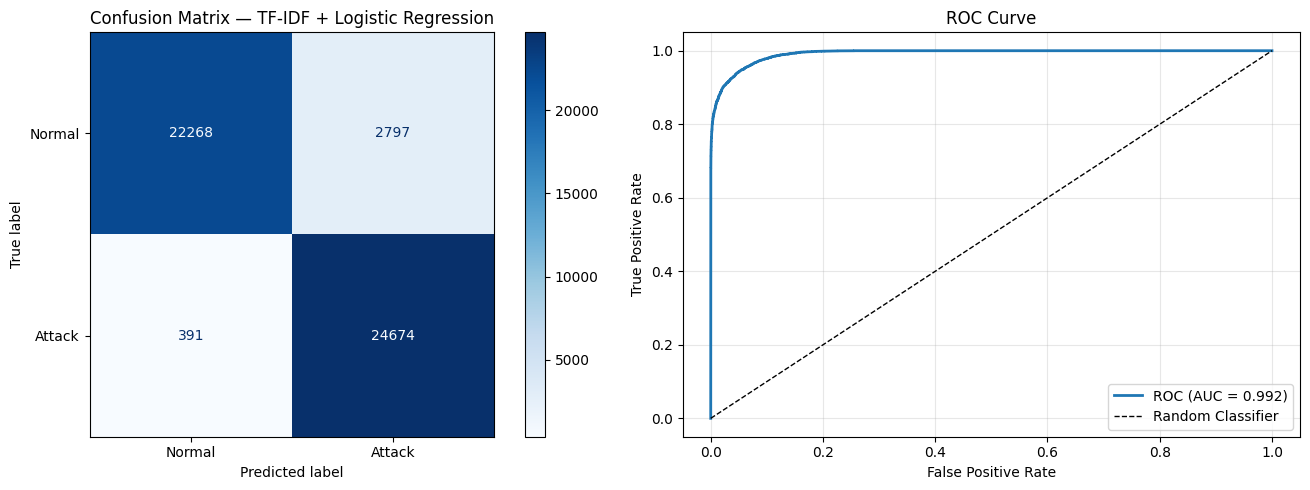


🔍 TOP FEATURES FOR EACH CLASS

🚨 Top 20 features indicating ATTACKS:
   a=                             → +10.6901
   /                              → +6.4320
   da=                            → +5.8569
   /&                             → +4.8817
   %                              → +4.7154
   '                              → +4.5433
   a=c                            → +3.6538
   oa=                            → +3.5843
   oa                             → +3.3480
   ga=                            → +3.2425
   sga                            → +3.1906
   ida                            → +3.0743
   ar/                            → +3.0719
   r/                             → +3.0507
   1a                             → +2.8949
   a=2                            → +2.8598
   b2a                            → +2.8523
   2a=                            → +2.8523
   1a=                            → +2.8089
   b1a                            → +2.8089

✅ Top 20 features indicating NORMAL traffic:
   

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer(
    lowercase=True,
    token_pattern=r'(?u)\b\w+\b|[<>\'";%\-\|&\(\)\[\]\{\}]',
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True,
    max_features=20000,
    analyzer='char_wb',
)

X_train = vectorizer.fit_transform(train_df["normalized_text"])
X_val   = vectorizer.transform(val_df["normalized_text"])
X_test  = vectorizer.transform(test_df_bal["normalized_text"])

y_train, y_val, y_test = train_df["label"], val_df["label"], test_df_bal["label"]

print(f"📊 Feature Matrix Shape:")
print(f"   Train: {X_train.shape}")
print(f"   Val: {X_val.shape}")
print(f"   Test: {X_test.shape}")

clf = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    C=1.0,
    penalty='l2',
    solver='lbfgs',
    n_jobs=-1
)
clf.fit(X_train, y_train)

y_val_pred = clf.predict(X_val)
print("\n📈 Validation Set Performance:")
print(classification_report(y_val, y_val_pred, target_names=["Normal", "Attack"]))

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

print("\n" + "="*80)
print("🎯 TEST SET PERFORMANCE (Balanced)")
print("="*80)
print(classification_report(y_test, y_pred, target_names=["Normal", "Attack"]))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n📊 ROC-AUC Score: {roc_auc:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Normal", "Attack"],
    cmap="Blues",
    ax=axes[0]
)
axes[0].set_title("Confusion Matrix — TF-IDF + Logistic Regression")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("🔍 TOP FEATURES FOR EACH CLASS")
print("="*80)

feature_names = vectorizer.get_feature_names_out()
coefficients = clf.coef_[0]

top_attack_indices = coefficients.argsort()[-20:][::-1]
print("\n🚨 Top 20 features indicating ATTACKS:")
for idx in top_attack_indices:
    print(f"   {feature_names[idx]:30s} → {coefficients[idx]:+.4f}")

top_normal_indices = coefficients.argsort()[:20]
print("\n✅ Top 20 features indicating NORMAL traffic:")
for idx in top_normal_indices:
    print(f"   {feature_names[idx]:30s} → {coefficients[idx]:+.4f}")

In [12]:
import joblib
import os

# Ensure save directory exists on mounted drive
save_dir = "/content/drive/MyDrive/CSIC2010/model_checkpoint"
os.makedirs(save_dir, exist_ok=True)

# Define paths
model_path = os.path.join(save_dir, "tfidf_logreg_model.joblib")
vectorizer_path = os.path.join(save_dir, "tfidf_vectorizer.joblib")

# Save model and vectorizer
joblib.dump(clf, model_path)
joblib.dump(vectorizer, vectorizer_path)

print(f"\n💾 Model saved to: {model_path}")
print(f"💾 Vectorizer saved to: {vectorizer_path}")


💾 Model saved to: /content/drive/MyDrive/CSIC2010/model_checkpoint/tfidf_logreg_model.joblib
💾 Vectorizer saved to: /content/drive/MyDrive/CSIC2010/model_checkpoint/tfidf_vectorizer.joblib


In [13]:
"""
Transformer-based Web Attack Detection using DistilBERT
Optimized for HTTP request classification
"""

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# ==================== Dataset Class ====================
class HTTPRequestDataset(Dataset):
    """Dataset for HTTP requests"""

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# ==================== Metrics Function ====================
def compute_metrics(pred):
    """Compute metrics for evaluation"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    probs = torch.softmax(torch.tensor(pred.predictions), dim=1)[:, 1].numpy()

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    # Only compute AUC if we have both classes
    try:
        auc = roc_auc_score(labels, probs)
    except:
        auc = 0.0

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }


# ==================== Training Function ====================
def train_transformer_waf(train_df, val_df, test_df,
                          model_name='distilbert-base-uncased',
                          max_length=512,
                          batch_size=16,
                          epochs=3,
                          learning_rate=2e-5):
    """
    Train a transformer model for WAF

    Args:
        train_df: Training dataframe with 'normalized_text' and 'label' columns
        val_df: Validation dataframe
        test_df: Test dataframe
        model_name: HuggingFace model name
        max_length: Maximum sequence length
        batch_size: Batch size for training
        epochs: Number of training epochs
        learning_rate: Learning rate

    Returns:
        trainer: Trained Trainer object
        results: Dictionary with test results
    """

    print("="*80)
    print("🚀 TRANSFORMER MODEL TRAINING")
    print("="*80)
    print(f"\n📋 Configuration:")
    print(f"   Model: {model_name}")
    print(f"   Max Length: {max_length}")
    print(f"   Batch Size: {batch_size}")
    print(f"   Epochs: {epochs}")
    print(f"   Learning Rate: {learning_rate}")

    # Load tokenizer and model
    print(f"\n⏳ Loading tokenizer and model...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        problem_type="single_label_classification"
    ).to(device)

    print(f"✅ Model loaded successfully!")
    print(f"   Parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")

    # Create datasets
    print(f"\n📦 Creating datasets...")
    train_dataset = HTTPRequestDataset(
        train_df['normalized_text'].values,
        train_df['label'].values,
        tokenizer,
        max_length
    )

    val_dataset = HTTPRequestDataset(
        val_df['normalized_text'].values,
        val_df['label'].values,
        tokenizer,
        max_length
    )

    test_dataset = HTTPRequestDataset(
        test_df['normalized_text'].values,
        test_df['label'].values,
        tokenizer,
        max_length
    )

    print(f"   Train size: {len(train_dataset)}")
    print(f"   Val size: {len(val_dataset)}")
    print(f"   Test size: {len(test_dataset)}")

    # Training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        warmup_steps=500,
        weight_decay=0.01,
        learning_rate=learning_rate,
        logging_dir='./logs',
        logging_steps=100,
        eval_strategy="steps",
        eval_steps=500,
        save_strategy="steps",
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        save_total_limit=2,
        fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
        dataloader_num_workers=2,
        report_to="none"  # Disable wandb/tensorboard
    )

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train
    print(f"\n🏋️  Training started...")
    print("="*80)
    trainer.train()

    # Evaluate on validation set
    print("\n" + "="*80)
    print("📊 VALIDATION SET RESULTS")
    print("="*80)
    val_results = trainer.evaluate(val_dataset)
    for key, value in val_results.items():
        if key.startswith('eval_'):
            print(f"   {key[5:]}: {value:.4f}")

    # Evaluate on test set
    print("\n" + "="*80)
    print("🎯 TEST SET RESULTS")
    print("="*80)
    test_results = trainer.evaluate(test_dataset)
    for key, value in test_results.items():
        if key.startswith('eval_'):
            print(f"   {key[5:]}: {value:.4f}")

    # Get predictions for confusion matrix
    predictions = trainer.predict(test_dataset)
    y_pred = predictions.predictions.argmax(-1)
    y_true = test_df['label'].values
    y_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'])
    axes[0].set_title('Confusion Matrix - Transformer Model')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # Plot ROC curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs)

    axes[1].plot(fpr, tpr, linewidth=2, label=f'Transformer (AUC = {auc:.3f})')
    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve - Transformer Model')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return results
    results = {
        'trainer': trainer,
        'tokenizer': tokenizer,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_probs': y_probs,
        'test_metrics': test_results
    }

    return results


# ==================== Prediction Function ====================
def predict_http_request(text, trainer, tokenizer, max_length=512):
    """
    Predict if an HTTP request is an attack

    Args:
        text: HTTP request text (normalized)
        trainer: Trained Trainer object
        tokenizer: Tokenizer
        max_length: Maximum sequence length

    Returns:
        dict with 'label', 'probability', and 'confidence'
    """
    # Tokenize
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    ).to(device)

    # Predict
    trainer.model.eval()
    with torch.no_grad():
        outputs = trainer.model(**encoding)
        probs = torch.softmax(outputs.logits, dim=1)[0]
        pred = torch.argmax(probs).item()

    return {
        'label': 'Attack' if pred == 1 else 'Normal',
        'attack_probability': probs[1].item(),
        'confidence': probs[pred].item()
    }



🔧 Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB


🚀 TRANSFORMER MODEL TRAINING

📋 Configuration:
   Model: microsoft/deberta-v3-small
   Max Length: 512
   Batch Size: 16
   Epochs: 3
   Learning Rate: 2e-05

⏳ Loading tokenizer and model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!
   Parameters: 141.90M

📦 Creating datasets...
   Train size: 9023
   Val size: 1003
   Test size: 50130

🏋️  Training started...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
500,0.115100,0.093402,0.967099,0.981481,0.952096,0.966565,0.995614
1000,0.038800,0.049816,0.986042,0.984095,0.988024,0.986056,0.999221
1500,0.015300,0.042887,0.990030,0.991984,0.988024,0.990000,0.999324



📊 VALIDATION SET RESULTS


   loss: 0.0429
   accuracy: 0.9900
   precision: 0.9920
   recall: 0.9880
   f1: 0.9900
   auc: 0.9993
   runtime: 9.8157
   samples_per_second: 102.1840
   steps_per_second: 3.2600

🎯 TEST SET RESULTS
   loss: 0.0287
   accuracy: 0.9927
   precision: 0.9935
   recall: 0.9918
   f1: 0.9927
   auc: 0.9996
   runtime: 478.4135
   samples_per_second: 104.7840
   steps_per_second: 3.2750


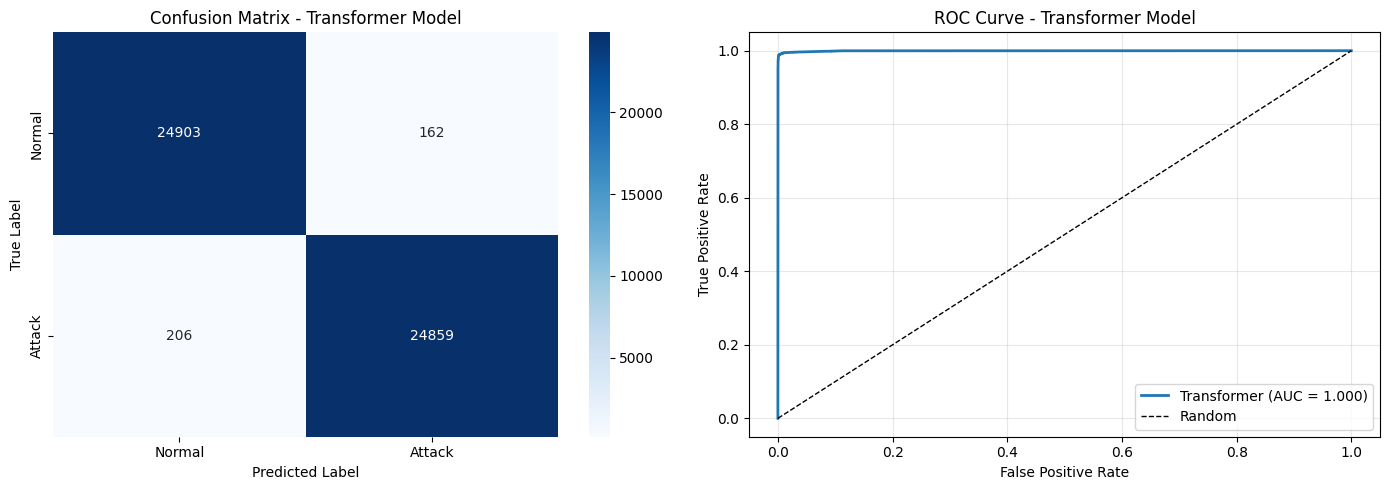

Prediction: {'label': 'Attack', 'attack_probability': 0.9999141693115234, 'confidence': 0.9999141693115234}


In [14]:
# Train the model
results = train_transformer_waf(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df_bal,
        # model_name='distilbert-base-uncased',
        # model_name='bert-base-uncased',      # More accurate but slower
    model_name='microsoft/deberta-v3-small',  # Good balance
    max_length=512,
    batch_size=16,
    epochs=3,
    learning_rate=2e-5
)

    # Make predictions
test_request = "GET /admin/../../etc/passwd HTTP/1.1"
prediction = predict_http_request(
test_request,
results['trainer'],
results['tokenizer']
)
print(f"Prediction: {prediction}")

In [17]:
import os
import json
from pathlib import Path


def save_model_to_drive(trainer, tokenizer, save_path='./trained_waf_model'):
    """
    Save the trained model and tokenizer to disk

    Args:
        trainer: Trained Trainer object
        tokenizer: Tokenizer
        save_path: Path to save the model
    """
    print("\n" + "="*80)
    print("💾 SAVING MODEL TO DISK")
    print("="*80)

    os.makedirs(save_path, exist_ok=True)

    # Save model
    print(f"📁 Saving to: {save_path}")
    trainer.model.save_pretrained(save_path)
    print("   ✅ Model saved")

    # Save tokenizer
    tokenizer.save_pretrained(save_path)
    print("   ✅ Tokenizer saved")

    # Save training config (optional but useful)
    import json
    config = {
        'model_name': trainer.model.config.name_or_path,
        'num_labels': trainer.model.config.num_labels,
        'max_length': 512,
        'training_completed': True
    }

    with open(os.path.join(save_path, 'training_config.json'), 'w') as f:
        json.dump(config, f, indent=2)
    print("   ✅ Training config saved")

    # Calculate model size
    total_size = sum(
        os.path.getsize(os.path.join(dirpath, filename))
        for dirpath, dirnames, filenames in os.walk(save_path)
        for filename in filenames
    )
    print(f"\n📊 Model Statistics:")
    print(f"   Total size: {total_size / (1024**2):.2f} MB")
    print(f"   Location: {os.path.abspath(save_path)}")
    print("\n✅ Model successfully saved!")

    return save_path


def load_model_from_drive(model_path='./trained_waf_model'):
    """
    Load a saved model and tokenizer from disk

    Args:
        model_path: Path where model is saved

    Returns:
        model: Loaded model
        tokenizer: Loaded tokenizer
    """
    print("\n" + "="*80)
    print("📂 LOADING MODEL FROM DISK")
    print("="*80)

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at: {model_path}")

    print(f"📁 Loading from: {model_path}")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    print("   ✅ Tokenizer loaded")

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    print("   ✅ Model loaded")

    # Load config if exists
    config_path = os.path.join(model_path, 'training_config.json')
    if os.path.exists(config_path):
        with open(config_path, 'r') as f:
            config = json.load(f)
        print(f"\n📋 Model Info:")
        print(f"   Original model: {config.get('model_name', 'Unknown')}")
        print(f"   Number of labels: {config.get('num_labels', 'Unknown')}")

    print("\n✅ Model successfully loaded!")

    return model, tokenizer


def predict_with_loaded_model(text, model, tokenizer, max_length=512):
    """
    Predict using a loaded model (without Trainer)

    Args:
        text: HTTP request text
        model: Loaded model
        tokenizer: Loaded tokenizer
        max_length: Maximum sequence length

    Returns:
        dict with prediction results
    """
    # Tokenize
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    ).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(**encoding)
        probs = torch.softmax(outputs.logits, dim=1)[0]
        pred = torch.argmax(probs).item()

    return {
        'label': 'Attack' if pred == 1 else 'Normal',
        'attack_probability': probs[1].item(),
        'confidence': probs[pred].item()
    }


# ==================== USAGE ====================

# After training, save the model
print("\n" + "="*80)
print("SAVING TRAINED MODEL")
print("="*80)

save_path = save_model_to_drive(
    trainer=results['trainer'],
    tokenizer=results['tokenizer'],
    save_path='./trained_waf_model'  # Change this to your preferred path
)

print(f"\n{'='*80}")
print("MODEL SAVED SUCCESSFULLY!")
print(f"{'='*80}")
print(f"You can now use this model anytime by loading it from: {save_path}")

# ==================== TEST LOADING ====================
print("\n" + "="*80)
print("TESTING MODEL LOADING")
print("="*80)

# Load the saved model
loaded_model, loaded_tokenizer = load_model_from_drive('./trained_waf_model')

# Test prediction with loaded model
test_requests = [
    "GET /admin/../../etc/passwd HTTP/1.1",
    "GET /index.html HTTP/1.1",
    "POST /login.php?id=1' OR '1'='1 HTTP/1.1"
]

print("\n" + "="*80)
print("TESTING PREDICTIONS WITH LOADED MODEL")
print("="*80)

for i, request in enumerate(test_requests, 1):
    prediction = predict_with_loaded_model(request, loaded_model, loaded_tokenizer)
    print(f"\n{i}. Request: {request}")
    print(f"   Prediction: {prediction['label']}")
    print(f"   Attack Probability: {prediction['attack_probability']:.4f}")
    print(f"   Confidence: {prediction['confidence']:.4f}")

print("\n" + "="*80)
print("✅ ALL DONE!")
print("="*80)


SAVING TRAINED MODEL

💾 SAVING MODEL TO DISK
📁 Saving to: ./trained_waf_model
   ✅ Model saved
   ✅ Tokenizer saved
   ✅ Training config saved

📊 Model Statistics:
   Total size: 551.91 MB
   Location: /content/trained_waf_model

✅ Model successfully saved!

MODEL SAVED SUCCESSFULLY!
You can now use this model anytime by loading it from: ./trained_waf_model

TESTING MODEL LOADING

📂 LOADING MODEL FROM DISK
📁 Loading from: ./trained_waf_model
   ✅ Tokenizer loaded
   ✅ Model loaded

📋 Model Info:
   Original model: microsoft/deberta-v3-small
   Number of labels: 2

✅ Model successfully loaded!

TESTING PREDICTIONS WITH LOADED MODEL

1. Request: GET /admin/../../etc/passwd HTTP/1.1
   Prediction: Attack
   Attack Probability: 0.9999
   Confidence: 0.9999

2. Request: GET /index.html HTTP/1.1
   Prediction: Normal
   Attack Probability: 0.0245
   Confidence: 0.9755

3. Request: POST /login.php?id=1' OR '1'='1 HTTP/1.1
   Prediction: Attack
   Attack Probability: 0.9999
   Confidence: 0.9